# <a id='наверх'>Кластеризация клиентов и их корзин</a>

#### [1. Загрузка библиотек](#Загрузка-библиотек)
#### [2. Загрузка датасета](#Загрузка-датасета)
#### [3. Подготовка данных для кластеризации](#Подготовка-данных-для-кластеризации)
#### [4. Кластеризация покупательских корзин](#Кластеризация-покупательских-корзин)
#### [5. Кластеризация клиентов](#Кластеризация-клиентов)
#### [6. Сохранение датасета](#Сохранение-датасета)

## <a id='Загрузка-библиотек'>Загрузка библиотек</a> 
###### [наверх](#наверх)

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

## <a id='Загрузка-датасета'>Загрузка датасета</a>
###### [наверх](#наверх)

In [2]:
# Загрузим датасет
df = pd.read_pickle('transaction_and_features.pkl')
df.head(3)

,id,purch_date,channel,category_name,category,description,item,price,quantity,turnover,...,check_av_quintity,check_av_item,frequence_client_per_month,days_between_min_max_date,recency_client,ltv_quantity_cumul,monetary,frequency,recency,elasticity_client
0,A6o1lNF4QoWbupw44vxNsw,2019-01-02,OFFLINE,"[""мешки строительные до 50 кг"", ""мешки для строительного мусора зеленые"", ""мешки для строительного мусора черные"", ""мешки для строительного мусора полипропиленовые"", ""мешки для строительного мусора пластиковые"", ""мешки строительные"", ""снижение цен на стройматериалы техническая"", ""стройматериалы"", ""строительные расходные материалы""]",др. строит. оборуд-е,мешок для строительного мусора 70 л 55x95 см полипропилен 85 мкм зеленый,10690746,9.0,2.47,22.23,...,81.140000,9.000000,30.500000,0,1094,2.47,22.23,1,0.0,elastic
1,C682dS8JSpaKaYlr5nqjhQ,2019-01-02,OFFLINE,"[""удлинители сетевые"", ""удлинители и тройники"", ""удлинитель 3 м"", ""электротовары""]",удлинители,удлинитель без заземления для маломощной техники 3 розетки 3 м цвет белый,18373471,183.0,2.47,452.01,...,13.309304,3.554348,0.084093,1094,0,2.47,452.01,1,0.0,elastic
2,G_tZ47JVT6ukGyuQYJyPRw,2019-01-02,OFFLINE,"[""семена цветов"", ""семена для выращивания цветов"", ""садок"", ""семена левкоя"", ""семена""]",семена,маттиола летний вечер» бп,18580648,1.0,14.80,14.80,...,51.663333,15.000000,0.007672,391,703,14.80,14.80,1,0.0,non_elastic


## <a id='Подготовка-данных-для-кластеризации'>Подготовка данных для кластеризации</a>
###### [наверх](#наверх)

In [3]:
# Оставим из датасета только те параметры, которые явлются постоянными для клиента
# (id, 
# суммарные ТО, кол-во товаров, кол-во чеков, кол-во дат с покупками, кол-во артикулов, 
# средние ТО, кол-во товаров в чеке, кол-во уник.артикулов в чеке, 
# давность, частотность, эластичность клиента)

df_const = df[['id', 'ltv_turnover', 'ltv_quantity', 'ltv_check_count', 'ltv_purch_date_count', 
            'ltv_item_count', 'check_av_turn', 'check_av_quintity', 'check_av_item', 
            'frequence_client_per_month', 'days_between_min_max_date', 
            'recency_client', 'elasticity_client']].drop_duplicates().reset_index().drop(columns='index')
df_const.head()

,id,ltv_turnover,ltv_quantity,ltv_check_count,ltv_purch_date_count,ltv_item_count,check_av_turn,check_av_quintity,check_av_item,frequence_client_per_month,days_between_min_max_date,recency_client,elasticity_client
0,A6o1lNF4QoWbupw44vxNsw,5959.09000,81.14000,1.0,1.0,9.0,5959.090000,81.140000,9.000000,30.500000,0,1094,elastic
1,C682dS8JSpaKaYlr5nqjhQ,342633.42636,1224.45598,92.0,92.0,327.0,3724.276373,13.309304,3.554348,0.084093,1094,0,elastic
2,G_tZ47JVT6ukGyuQYJyPRw,37968.66000,154.99000,3.0,3.0,45.0,12656.220000,51.663333,15.000000,0.007672,391,703,non_elastic
3,_LqM1wqaQpSi-wdvuU0KjA,188953.86000,798.16000,14.0,14.0,178.0,13496.704286,57.011429,12.714286,0.014403,972,122,non_elastic
4,5f0GnxxlQSG7yIvzMecH8A,249300.49060,941.39030,102.0,102.0,248.0,2444.122457,9.229317,2.431373,0.118600,860,234,elastic


In [4]:
# Составим список категорий товаров по каждому клиенту
cat_list = df.groupby(['id'], as_index=False)['category'].apply(lambda x: list(set(x)))

# Добавим список категорий как фичу, характеризующую клиента
df_const = df_const.merge(cat_list, on='id', how='left')
df_const.head(1)

,id,ltv_turnover,ltv_quantity,ltv_check_count,ltv_purch_date_count,ltv_item_count,check_av_turn,check_av_quintity,check_av_item,frequence_client_per_month,days_between_min_max_date,recency_client,elasticity_client,category
0,A6o1lNF4QoWbupw44vxNsw,5959.09,81.14,1.0,1.0,9.0,5959.09,81.14,9.0,30.5,0,1094,elastic,"[др. строит. оборуд-е, акс. д/сверл./прив., акс.д/шлифования, технич.уход и защита, ср-ва индивид.защиты]"


## <a id='Кластеризация-покупательских-корзин'>Кластеризация покупательских корзин</a>
###### [наверх](#наверх)

In [10]:
# Список всех категорий товаров
all_cats = df.category.unique()

In [11]:
# Создаем объект LabelEncoder 
labelEncoder_cat = LabelEncoder() 

# Обрабатываем все имеющиеся позиции категорий товаров
labelEncoder_cat.fit(all_cats) 

LabelEncoder()

In [12]:
# Посчитаем количество уникальных категорий
max_cat_count = max(labelEncoder_cat.transform(all_cats)) + 1 
print('Всего уникальных категорий:', max_cat_count)

Всего уникальных категорий: 796


In [13]:
# Список всех корзин клиентов датасета (в терминах категорий товаров)
cat_carts = df_const.category.values

In [14]:
# Создаем список индексов для каждой корзины с категориями
cat_carts_indexes = [labelEncoder_cat.transform(c) for c in cat_carts] 

In [16]:
def changeXTo01(trainVector, wordsCount):
    '''
    Функция преобразования вектора по приницпу bag of words
    Входные параметры:
        - trainVector - исходный вектор индексов слов
        - wordsCount - установленная длинна вектора
    Функция возращает: 
        - сформированный вектор из 0 и 1
    '''    
    out = np.zeros(wordsCount)                   # Создаем вектор из нулей длинной wordsCount (кол-во уникальных категорий)
    for x in trainVector:                        # Пробегаем по всем индексам в trainVector
        out[x] = 1                               # Изменяем на 1 значение out в позиции текущего индекса 
    return out                                   # Возвращаем сформированный вектор


def changeSetTo01(trainSet, wordsCount):
    '''
    Функция преобразования выборки (обучающей или проверочной) по принципе Bag of words
    Входные параметры:
        - trainSet - выборка
        - wordsCount - установленная длинна вектора
    Функция возращает: 
        - сформированная выборка из 0 и 1
    '''    
    out = []                                     # Создаем пустой список  
    for x in trainSet:                           # Пробегаем по всем элемента выборки
        out.append(changeXTo01(x, wordsCount))   # Получаем вектор Bag of words для текущего элемента    
    return np.array(out)   

In [17]:
# Создаем выборку по принципу bag of words
cat_carts01 = changeSetTo01(cat_carts_indexes, max_cat_count) 

In [18]:
n = 0                       # Укажем номер корзины
print(cat_carts[n])         # Отобразим категории этой корзины
print(cat_carts_indexes[n]) # Отобразим соответствующие индексы
print(cat_carts01[n])       # Выводим соответсвующий список bag of words

['др. строит. оборуд-е', 'акс. д/сверл./прив.', 'акс.д/шлифования', 'технич.уход и защита', 'ср-ва индивид.защиты']
[168  18  20 639 605]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [19]:
cur_time = time.time()

# Создаем объект KMeans
kmean = KMeans(n_clusters=920, random_state=42)   

# Производим кластеризацию набора cat_carts01
kmean.fit(cat_carts01)     

# Сохраняем метки в переменную labels_carts
labels_carts = kmean.labels_                               

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  2386.98 c


In [20]:
# Добавим метки в датасет
cluster_cart = pd.DataFrame(labels_carts.tolist(), columns=['cluster_cart'])
df_const_clust = pd.concat([df_const, cluster_cart], ignore_index=False, axis=1)
df_const_clust.head(1)

,id,ltv_turnover,ltv_quantity,ltv_check_count,ltv_purch_date_count,ltv_item_count,check_av_turn,check_av_quintity,check_av_item,frequence_client_per_month,days_between_min_max_date,recency_client,elasticity_client,category,cluster_cart
0,A6o1lNF4QoWbupw44vxNsw,5959.09,81.14,1.0,1.0,9.0,5959.09,81.14,9.0,30.5,0,1094,elastic,"[др. строит. оборуд-е, акс. д/сверл./прив., акс.д/шлифования, технич.уход и защита, ср-ва индивид.защиты]",25


## <a id='Кластеризация-клиентов'>Кластеризация клиентов</a>
###### [наверх](#наверх)

In [21]:
def clustering_viz(users, label_col):
    '''
      Функция визуализации данных после кластеризации
    '''
    plt.figure(figsize=(10, 10))
    for label in users[label_col].unique():
        if label != -1:
            tmp = users[users[label_col] == label]
            plt.scatter(tmp['tsne_1'], tmp['tsne_2'], label=label)

In [22]:
def getParameterElasticityClient(arg):
    '''
    Функция получения данных об эластичности клиента
    Входные данные: arg - строка данных (для данной функции передаем 13 колонку из таблицы)    
    Функция возвращает: OHE эластичность клиента
    '''
    out = [0, 0]           
    if(arg == 'elastic'):
        out[0] = 1
    elif(arg == 'non_elastic'):
        out[1] = 1 
    return out  # Возвращаем OHE представление эластичности клиента


def getAllParameters(val):
    '''
      Функция получения полного набора данных по одной записе из базы
        Входные данные:
          - val - запись из базы
        Функция возвращает:
          - массив числовых данных, соответствующий исходной записи
    '''    
    ltv_turnover = [val[1]]
    ltv_quantity = [val[2]]
    ltv_check_count = [val[3]]
    ltv_purch_date_count = [val[4]]
    ltv_item_count = [val[5]]
    check_av_turn = [val[6]]
    check_av_quintity = [val[7]]
    check_av_item = [val[8]]
    frequence_client_per_month = [val[9]]
    days_between_min_max_date = [val[10]]
    recency_client = [val[11]]
    elasticity_client = getParameterElasticityClient(val[12])    # Получаем эластичность клиента
    out = []                                                     # Создаем пустой список
    out += ltv_turnover
    out += ltv_quantity
    out += ltv_check_count
    out += ltv_purch_date_count
    out += ltv_item_count
    out += check_av_turn
    out += check_av_quintity
    out += check_av_item
    out += frequence_client_per_month
    out += days_between_min_max_date
    out += recency_client
    out += elasticity_client
    return out  


def get01Data(values):
    '''
      Функция получения обучающей выборки
        Входные данные: - values - данные из базы
        Функция возвращает: - df_const_01 соответсвующие данным обучающей выборки
    '''    
    df_const_01 = []                             # Создаем пустой df_const_01
    for val in values:                           # Пробегаем по всем записям базы
        x = getAllParameters(val)                # Получаем полный набор данных о текущей записи val
        df_const_01.append(x)                    # Добавляем полученные данные df_const_01
    df_const_01 = np.array(df_const_01)          # Переводим в numpy
    return (df_const_01)       

In [23]:
# Преобразуем датасет в числовой numpy-массив
const_01 = get01Data(df_const[['id', 'ltv_turnover', 'ltv_quantity', 'ltv_check_count', 'ltv_purch_date_count',
                               'ltv_item_count', 'check_av_turn', 'check_av_quintity', 'check_av_item',
                               'frequence_client_per_month', 'days_between_min_max_date',
                               'recency_client', 'elasticity_client']].values)

In [24]:
# Создаем объект StandardScaler для стандартного распределения
data01Scaler = StandardScaler()

# Создаем набор данных со стандартным распределением
const_01_Scaled = data01Scaler.fit_transform(const_01) 
df_const_01_Scaled = pd.DataFrame(const_01_Scaled, columns=[
    'ltv_turnover', 'ltv_quantity', 'ltv_check_count',
    'ltv_purch_date_count', 'ltv_item_count', 'check_av_turn',
    'check_av_quintity', 'check_av_item', 'frequence_client_per_month',
    'days_between_min_max_date', 'recency_client', 'elastic', 'non_elastic'])

In [25]:
# Понизим размерность наших данных до 2, для визуализации
cur_time = time.time()
tsne = TSNE(n_components=2, random_state=2)
comps_tsne = tsne.fit_transform(const_01_Scaled)
print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  906.23 c


In [26]:
# Добавим, полученные после снижения размерности точки в датасет со стандартными распределениями данных с предыдущего пункта
df_const_01_Scaled['tsne_1'] = comps_tsne[:, 0]
df_const_01_Scaled['tsne_2'] = comps_tsne[:, 1]

In [27]:
cur_time = time.time()

# Создаем объект KMeans
kmean_10 = KMeans(n_clusters=10)

# Производим кластеризацию набора const_01_Scaled
kmean_10.fit(const_01_Scaled)

# Сохраняем метки в переменную labels
labels_kmean_10 = kmean_10.labels_ 

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  3.04 c


In [28]:
# Добавим метки в датасет
df_const_01_Scaled['label_kmeans_10'] = labels_kmean_10

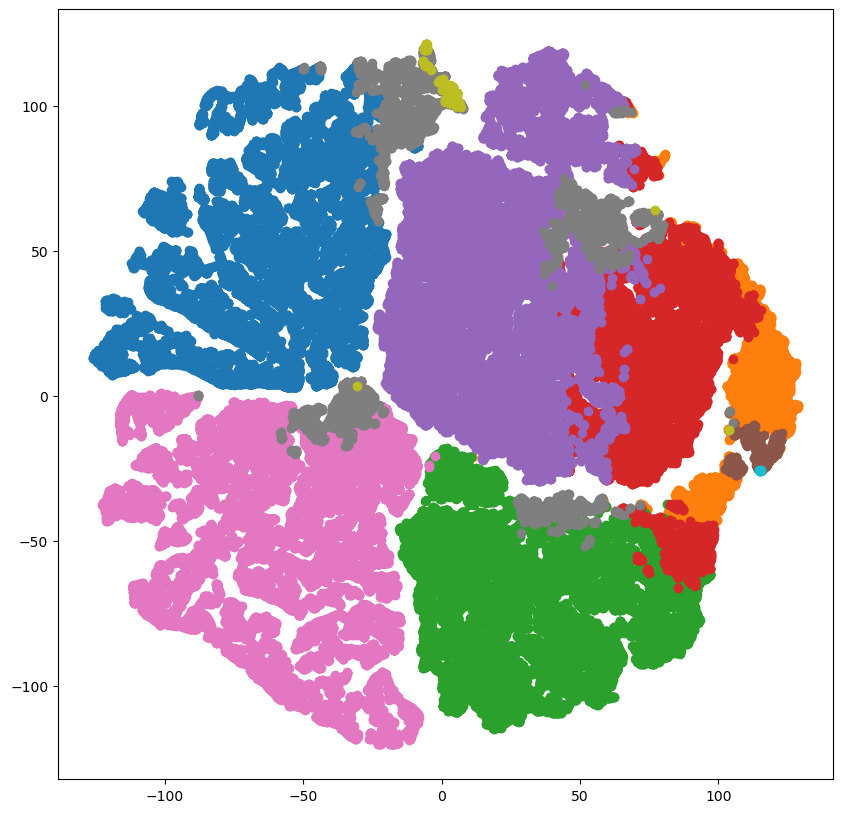

In [29]:
# Визулизируем данные с метками, полученными с помощью kmeans
clustering_viz(df_const_01_Scaled, 'label_kmeans_10')

In [30]:
score = silhouette_score(df_const_01_Scaled, kmean_10.labels_)

print("Качество кластеризации по метрике силуэтта %.3f" % score)

Качество кластеризации по метрике силуэтта 0.205


In [31]:
cur_time = time.time()

# Создаем объект DBSCAN и произведём кластеризацию набора const_01_Scaled
model_dbscan = DBSCAN().fit(const_01_Scaled)

# Сохраняем метки в переменную labels_dbscan
labels_dbscan = model_dbscan.labels_
uniq_labels = np.unique(labels_dbscan)
n_clusters = len(uniq_labels[uniq_labels != -1])

print('Время обработки: ', round(time.time() - cur_time,2),'c')
print(f'Кластеров: {n_clusters}')

Время обработки:  21.66 c
Кластеров: 93


In [32]:
# Добавим метки в датасет
df_const_01_Scaled['label_dbscan'] = labels_dbscan

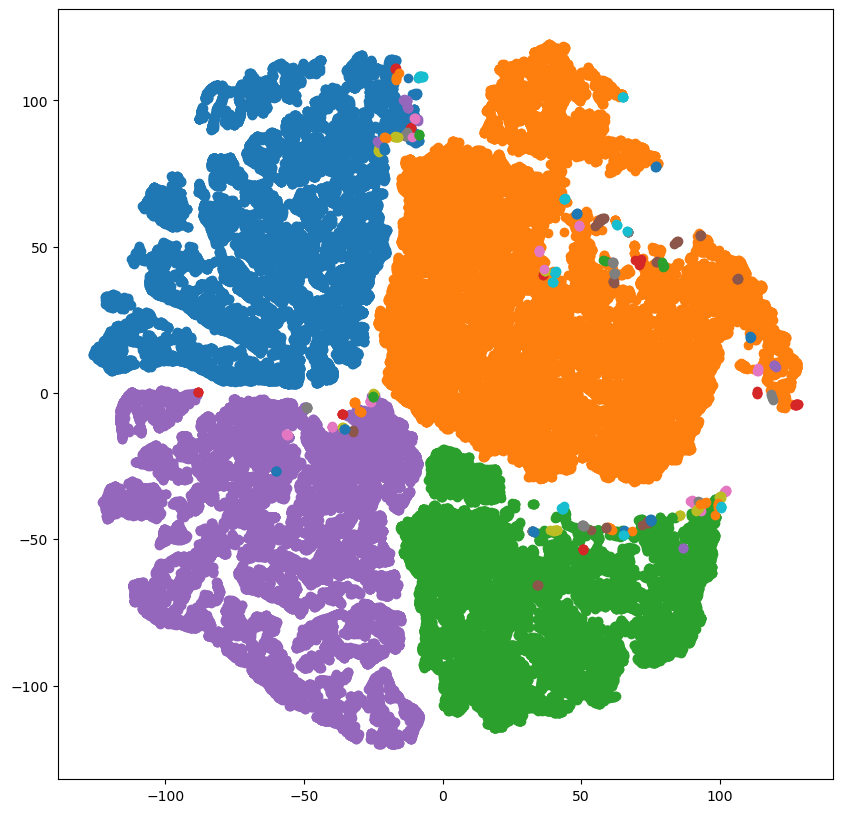

In [33]:
# Визулизируем данные с метками, полученными с помощью dbscan
clustering_viz(df_const_01_Scaled, 'label_dbscan')

In [34]:
score = silhouette_score(df_const_01_Scaled, labels_dbscan)

print("Качество кластеризации по метрике силуэтта %.3f" % score)

Качество кластеризации по метрике силуэтта -0.245


In [35]:
df_const_01_Scaled.head(3)

,ltv_turnover,ltv_quantity,ltv_check_count,ltv_purch_date_count,ltv_item_count,check_av_turn,check_av_quintity,check_av_item,frequence_client_per_month,days_between_min_max_date,recency_client,elastic,non_elastic,tsne_1,tsne_2,label_kmeans_10,label_dbscan
0,-0.377238,-0.199843,-0.383635,-0.383320,-0.334612,-0.453548,0.765435,0.645854,1.187203,-0.693869,3.108352,0.844296,-0.844296,-54.058540,110.690369,1,2
1,1.258631,1.419245,5.256719,5.287784,3.265237,-0.537786,-0.342766,-0.310787,-0.844249,2.760899,-1.173282,0.844296,-0.844296,127.024406,-4.217716,4,-1
2,-0.221707,-0.095261,-0.259671,-0.258681,0.072918,-0.201109,0.283852,1.699877,-0.849353,0.540879,1.578079,-1.184419,1.184419,24.151089,-36.031151,5,-1


In [36]:
# Добавим полученные метки в исходный датасет df_const
df_const_clust = pd.concat([df_const_clust[['id', 'ltv_turnover', 'ltv_quantity', 'ltv_check_count', 'ltv_purch_date_count',
                                            'ltv_item_count', 'check_av_turn', 'check_av_quintity', 'check_av_item',
                                            'frequence_client_per_month', 'days_between_min_max_date',
                                            'recency_client', 'elasticity_client', 'cluster_cart']], 
                            df_const_01_Scaled[['label_dbscan', 'label_kmeans_10']]],
                           ignore_index=False, 
                           axis=1)
df_const_clust.head(3)

,id,ltv_turnover,ltv_quantity,ltv_check_count,ltv_purch_date_count,ltv_item_count,check_av_turn,check_av_quintity,check_av_item,frequence_client_per_month,days_between_min_max_date,recency_client,elasticity_client,cluster_cart,label_dbscan,label_kmeans_10
0,A6o1lNF4QoWbupw44vxNsw,5959.09000,81.14000,1.0,1.0,9.0,5959.090000,81.140000,9.000000,30.500000,0,1094,elastic,25,2,1
1,C682dS8JSpaKaYlr5nqjhQ,342633.42636,1224.45598,92.0,92.0,327.0,3724.276373,13.309304,3.554348,0.084093,1094,0,elastic,540,-1,4
2,G_tZ47JVT6ukGyuQYJyPRw,37968.66000,154.99000,3.0,3.0,45.0,12656.220000,51.663333,15.000000,0.007672,391,703,non_elastic,137,-1,5


In [38]:
# Добавим полученные метки в исходный датасет df
df = df.merge(df_const_clust[['id', 'cluster_cart', 'label_dbscan', 'label_kmeans_10']], on='id', how='left')

## <a id='Сохранение-датасета'>Сохранение датасета</a>
###### [наверх](#наверх)

In [41]:
df.to_pickle('transaction_and_features_2.pkl')